# LSTM Stock Predictor Using Fear and Greed Index

In this notebook, you will build and train a custom LSTM RNN that uses a 10 day window of Bitcoin fear and greed index values to predict the 11th day closing price. 

You will need to:

1. Prepare the data for training and testing
2. Build and train a custom LSTM RNN
3. Evaluate the performance of the model

## Data Preparation

In this section, you will need to prepare the training and testing data for the model. The model will use a rolling 10 day window to predict the 11th day closing price.

You will need to:
1. Use the `window_data` function to generate the X and y values for the model.
2. Split the data into 70% training and 30% testing
3. Apply the MinMaxScaler to the X and y values
4. Reshape the X_train and X_test data for the model. Note: The required input format for the LSTM is:

```python
reshape((X_train.shape[0], X_train.shape[1], 1))
```

In [16]:
import numpy as np
import pandas as pd
import hvplot.pandas

In [17]:
# Set the random seed for reproducibility
# Note: This is for the homework solution, but it is good practice to comment this out and run multiple experiments to evaluate your model
from numpy.random import seed
seed(1)
from tensorflow import random
random.set_seed(2)

In [18]:
# Load the fear and greed sentiment data for Bitcoin
df = pd.read_csv('btc_sentiment.csv', index_col="date", infer_datetime_format=True, parse_dates=True)
df = df.drop(columns="fng_classification")
df.head()

,fng_value
date,
2019-07-29,19
2019-07-28,16
2019-07-27,47
2019-07-26,24
2019-07-25,42


In [19]:
# Load the historical closing prices for Bitcoin
df2 = pd.read_csv('btc_historic.csv', index_col="Date", infer_datetime_format=True, parse_dates=True)['Close']
df2 = df2.sort_index()
df2.tail()

Date
2019-07-25    9882.429688
2019-07-26    9847.450195
2019-07-27    9478.320313
2019-07-28    9531.769531
2019-07-29    9529.889648
Name: Close, dtype: float64

In [20]:
# Join the data into a single DataFrame
df = df.join(df2, how="inner")
df.tail()

,fng_value,Close
2019-07-25,42,9882.429688
2019-07-26,24,9847.450195
2019-07-27,47,9478.320313
2019-07-28,16,9531.769531
2019-07-29,19,9529.889648


In [21]:
df.head()

,fng_value,Close
2018-02-01,30,9114.719727
2018-02-02,15,8870.820313
2018-02-03,40,9251.269531
2018-02-04,24,8218.049805
2018-02-05,11,6937.080078


In [22]:
# This function accepts the column number for the features (X) and the target (y)
# It chunks the data up with a rolling window of Xt-n to predict Xt
# It returns a numpy array of X any y
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

In [23]:
# Predict Closing Prices using a 10 day window of previous fng values
# Then, experiment with window sizes anywhere from 1 to 10 and see how the model performance changes
window_size = 10

# Column index 0 is the 'fng_value' column
# Column index 1 is the `Close` column
feature_column = 0
target_column = 1
X, y = window_data(df, window_size, feature_column, target_column)

In [24]:
# Use 70% of the data for training and the remainder for testing

percentile = int(0.7 * len(X))

# Create the X_train data using percentile as a benchmark
X_train = X[: percentile - 1]

# Create the X_test data using percentile as a demarkation point
X_test = X[percentile:]

# Create the y_train data using percentile as a benchmark (same as above)
y_train = y[: percentile - 1]

# Create the y_test data using percentile as a demarkation point (same as above)
y_test = y[percentile:]

In [25]:
from sklearn.preprocessing import MinMaxScaler
# Use the MinMaxScaler to scale data between 0 and 1.

# Instantantiate MinMaxScaler and assign it to a variable
scaler = MinMaxScaler()

# Fit X using MinMaxScaler
scaler.fit(X)

# Tranform X_train
X_train = scaler.transform(X_train)

# Transform X_test
X_test = scaler.transform(X_test)

# Fit Y using MinMaxScaler
scaler.fit(y)

# Tranform y_train
y_train = scaler.transform(y_train)

# Transform y_test
y_test = scaler.transform(y_test)

In [26]:
# Reshape the features for the model

# Reshape X_train
X_train = X_train.reshape(
    (X_train.shape[0], 
     X_train.shape[1],
     1)
)

# Reshape X_test
X_test = X_test.reshape(
    (X_test.shape[0],
     X_test.shape[1],
     1)
)

---

## Build and Train the LSTM RNN

In this section, you will design a custom LSTM RNN and fit (train) it using the training data.

You will need to:
1. Define the model architecture
2. Compile the model
3. Fit the model to the training data

### Hints:
You will want to use the same model architecture and random seed for both notebooks. This is necessary to accurately compare the performance of the FNG model vs the closing price model. 

In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [28]:
# Build the LSTM model. 
# The return sequences need to be set to True if you are adding additional LSTM layers, but 
# You don't have to do this for the final layer. 
# Note: The dropouts help prevent overfitting
# Note: The input shape is the number of time steps and the number of indicators
# Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# Instantantiate Sequential and assign it to a variable
sequence = Sequential()

# Define the number of steps in the LSTM sequence/ model
number_of_units = 30

# Define the rate at which dropouts will occur
dropout_ratio = 0.2

# Add the first layer
sequence.add(LSTM(
    units = number_of_units,
    return_sequences = True,
    input_shape = (X_train.shape[1],1)
)
            )

# Add the dropout layer
sequence.add(Dropout(dropout_ratio))

# Add the second layer
sequence.add(LSTM(
    units = number_of_units,
    return_sequences = True,
        )
            )

# Add the dropout layer
sequence.add(Dropout(dropout_ratio))

# Add the third layer
sequence.add(LSTM(
    units = number_of_units,
    return_sequences = False,
        )
            )

# Add the dropout layer
sequence.add(Dropout(dropout_ratio))

# Add the density node/ layer
sequence.add(Dense(1))

In [29]:
# Compile the model

sequence.compile(optimizer="adam", loss="mean_squared_error")

In [30]:
# Summarize the model

sequence.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 10, 30)            3840      
_________________________________________________________________
dropout (Dropout)            (None, 10, 30)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 10, 30)            7320      
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 30)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 30)                7320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 3

In [31]:
# Train the model
# Use at least 10 epochs
# Do not shuffle the data
# Experiement with the batch size, but a smaller batch size is recommended

sequence.fit(X_train, y_train, epochs = 50, shuffle = False, batch_size = 10, verbose=1)

Epoch 1/50
38/38 [==============================] - 24s 35ms/step - loss: 0.0901
Epoch 2/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0737
Epoch 3/50
38/38 [==============================] - 1s 35ms/step - loss: 0.0565
Epoch 4/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0579
Epoch 5/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0563
Epoch 6/50
38/38 [==============================] - 1s 35ms/step - loss: 0.0490
Epoch 7/50
38/38 [==============================] - 1s 35ms/step - loss: 0.0514
Epoch 8/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0491
Epoch 9/50
38/38 [==============================] - 1s 35ms/step - loss: 0.0481
Epoch 10/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0466
Epoch 11/50
38/38 [==============================] - 1s 34ms/step - loss: 0.0455
Epoch 12/50
38/38 [==============================] - 1s 36ms/step - loss: 0.0469
Epoch 13/50
38/38 [=================

---

## Model Performance

In this section, you will evaluate the model using the test data. 

You will need to:
1. Evaluate the model using the `X_test` and `y_test` data.
2. Use the X_test data to make predictions
3. Create a DataFrame of Real (y_test) vs predicted values. 
4. Plot the Real vs predicted values as a line chart

### Hints
Remember to apply the `inverse_transform` function to the predicted and y_test values to recover the actual closing prices.

In [32]:
# Evaluate the model

sequence.evaluate(X_test, y_test)

5/5 [==============================] - 5s 12ms/step - loss: 0.0816


0.0815969854593277

In [33]:
# Make some predictions

predicted = sequence.predict(X_test)

In [34]:
# Recover the original prices instead of the scaled version
price_prediction = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

In [35]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real Price": real_prices.ravel(),
    "Predicted Price": price_prediction.ravel()
}, index = df.index[-len(real_prices): ]) 
stocks.head()

,Real Price,Predicted Price
2019-02-20,3924.239990,7036.291016
2019-02-21,3974.050049,7232.752930
2019-02-22,3937.040039,7435.602051
2019-02-23,3983.530029,7676.793945
2019-02-24,4149.089844,7867.911621


<AxesSubplot:>

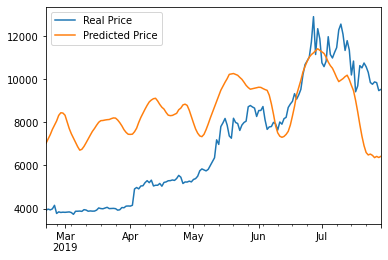

In [36]:
# Plot the real vs predicted values as a line chart
stocks.plot.line()

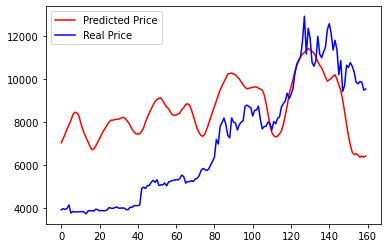

In [37]:
import matplotlib.pyplot as plt

plt.plot(price_prediction,color='red', label='Predicted Price')

plt.plot(real_prices,color='blue', label='Real Price')

plt.legend(loc='upper left')

plt.show()